### Song based sentiment analysis using Textblob

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of n songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Electronic",
    2: "Folk",
    3: "Hip-Hop",
    4: "Indie",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "R&B",
    9: "Rock"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,With just an empty two-room flat but eyes full...
1,Country,The time has come for me to leave you cryin' B...
2,Country,"If I weren't leavin', would I catch you dreami..."
3,Country,[ Bill ] Tonight in the darkness I was awakene...
4,Country,"1.\tYeah, way down yonder on the Chattahoochee..."
5,Country,I had one kiss too many and it went right to m...
6,Country,You got out with no bruises or scratches You b...
7,Country,The pale moon was rising above the green mount...
8,Country,Well daisy duke peek-a-boo I might've learned ...
9,Country,Fuzzy was an outlaw swamp rat born and raised ...


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,with just empty two-room flat eyes full dreams...
1,Country,time come leave cryin love priceless when stai...
2,Country,weren leavin would catch dreamin weren gonna g...
3,Country,bill tonight darkness awakened knock door know...
4,Country,"yeah, down yonder chattahoochee yeah brittney ..."
...,...,...
9995,Rock,there snake coming darkness parade from paradi...
9996,Rock,(mick jagger keith richards) everywhere hear s...
9997,Rock,"well, when young never been kissed thinkin ove..."
9998,Rock,well they moved down they crawled around walki...


## Remove stopwords and Tokenize

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# tokenization
song_data_processed['Tokens'] = song_data_processed['Lyrics'].apply(lambda x: x.split())

# remove stop-words
song_data_processed['Tokens'] = song_data_processed['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(song_data_processed)):
    t = ' '.join(song_data_processed['Tokens'][i])
    detokenized_doc.append(t)

song_data_processed['CleanLyrics'] = detokenized_doc
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics
0,Country,with just empty two-room flat eyes full dreams...,"[empty, two-room, flat, eyes, full, dreams, ro...",empty two-room flat eyes full dreams rooms hop...
1,Country,time come leave cryin love priceless when stai...,"[time, come, leave, cryin, love, priceless, st...",time come leave cryin love priceless stained t...
2,Country,weren leavin would catch dreamin weren gonna g...,"[leavin, would, catch, dreamin, gonna, gone, n...","leavin would catch dreamin gonna gone now, cou..."
3,Country,bill tonight darkness awakened knock door know...,"[bill, tonight, darkness, awakened, knock, doo...",bill tonight darkness awakened knock door know...
4,Country,"yeah, down yonder chattahoochee yeah brittney ...","[yeah,, yonder, chattahoochee, brittney, spear...","yeah, yonder chattahoochee brittney spears lit..."
...,...,...,...,...
9995,Rock,there snake coming darkness parade from paradi...,"[snake, coming, darkness, parade, paradise, ne...",snake coming darkness parade paradise need ede...
9996,Rock,(mick jagger keith richards) everywhere hear s...,"[(mick, jagger, keith, richards), everywhere, ...",(mick jagger keith richards) everywhere hear s...
9997,Rock,"well, when young never been kissed thinkin ove...","[well,, young, never, kissed, thinkin, much, m...","well, young never kissed thinkin much missed g..."
9998,Rock,well they moved down they crawled around walki...,"[well, moved, crawled, around, walkin, sideway...",well moved crawled around walkin sideways side...


In [8]:
song_data_processed['Polarity'] = song_data_processed['CleanLyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
song_data_processed['Subjectivity'] = song_data_processed['CleanLyrics'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [9]:
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics,Polarity,Subjectivity
0,Country,with just empty two-room flat eyes full dreams...,"[empty, two-room, flat, eyes, full, dreams, ro...",empty two-room flat eyes full dreams rooms hop...,0.301923,0.545940
1,Country,time come leave cryin love priceless when stai...,"[time, come, leave, cryin, love, priceless, st...",time come leave cryin love priceless stained t...,0.264669,0.640909
2,Country,weren leavin would catch dreamin weren gonna g...,"[leavin, would, catch, dreamin, gonna, gone, n...","leavin would catch dreamin gonna gone now, cou...",0.288462,0.480769
3,Country,bill tonight darkness awakened knock door know...,"[bill, tonight, darkness, awakened, knock, doo...",bill tonight darkness awakened knock door know...,0.131250,0.422917
4,Country,"yeah, down yonder chattahoochee yeah brittney ...","[yeah,, yonder, chattahoochee, brittney, spear...","yeah, yonder chattahoochee brittney spears lit...",0.128279,0.547480
...,...,...,...,...,...,...
9995,Rock,there snake coming darkness parade from paradi...,"[snake, coming, darkness, parade, paradise, ne...",snake coming darkness parade paradise need ede...,0.125000,0.639167
9996,Rock,(mick jagger keith richards) everywhere hear s...,"[(mick, jagger, keith, richards), everywhere, ...",(mick jagger keith richards) everywhere hear s...,0.019351,0.510714
9997,Rock,"well, when young never been kissed thinkin ove...","[well,, young, never, kissed, thinkin, much, m...","well, young never kissed thinkin much missed g...",0.196212,0.467424
9998,Rock,well they moved down they crawled around walki...,"[well, moved, crawled, around, walkin, sideway...",well moved crawled around walkin sideways side...,0.100000,0.550000


### Explore the results

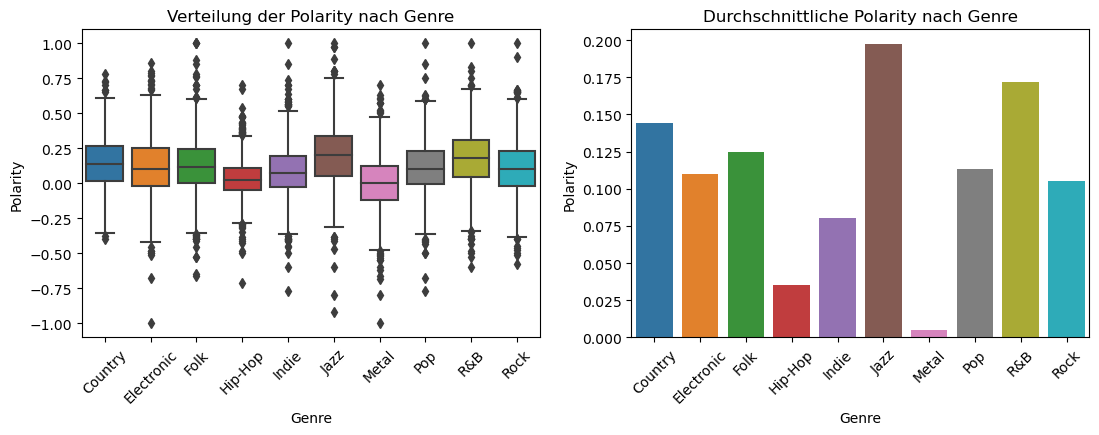

In [10]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.boxplot(x='Genre', y='Polarity', data=song_data_processed)
plt.title('Verteilung der Polarity nach Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed


plt.subplot(1,2,2)
sns.barplot(x='Genre', y='Polarity', data=song_data_processed, errorbar=None)
plt.title('Durchschnittliche Polarity nach Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

plt.show()

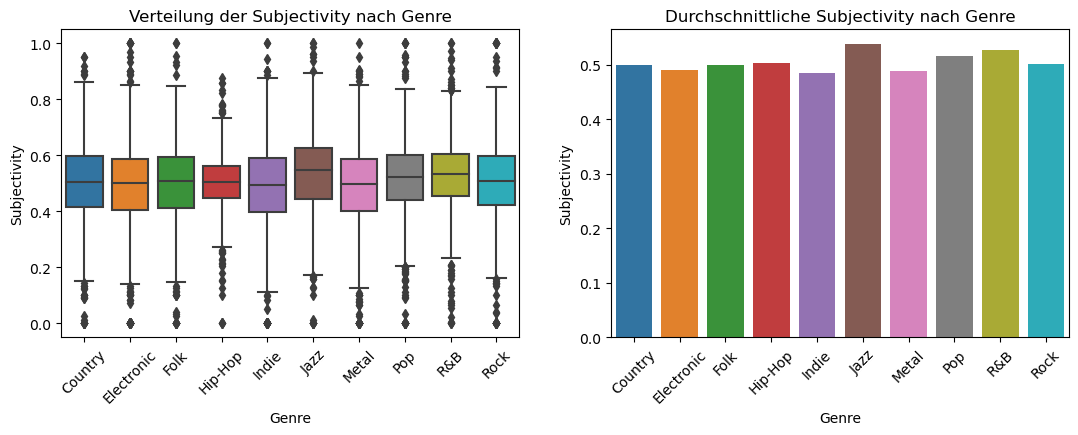

In [11]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.boxplot(x='Genre', y='Subjectivity', data=song_data_processed)
plt.title('Verteilung der Subjectivity nach Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed


plt.subplot(1,2,2)
sns.barplot(x='Genre', y='Subjectivity', data=song_data_processed, errorbar=None)
plt.title('Durchschnittliche Subjectivity nach Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

plt.show()

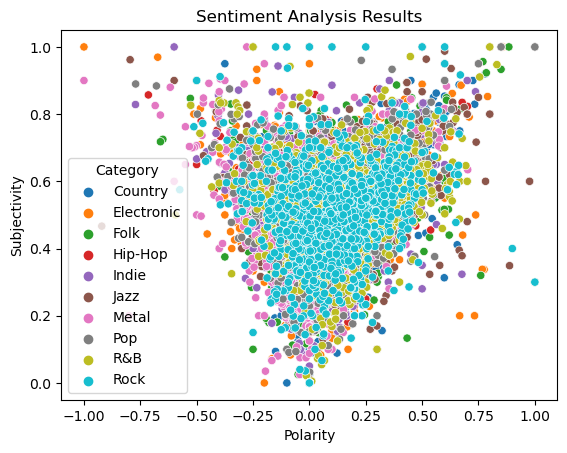

In [12]:
#Scatter Plot
sns.scatterplot(x='Polarity', y='Subjectivity', hue='Genre', data=song_data_processed)
plt.title('Sentiment Analysis Results')
plt.legend(title='Category')
plt.show()

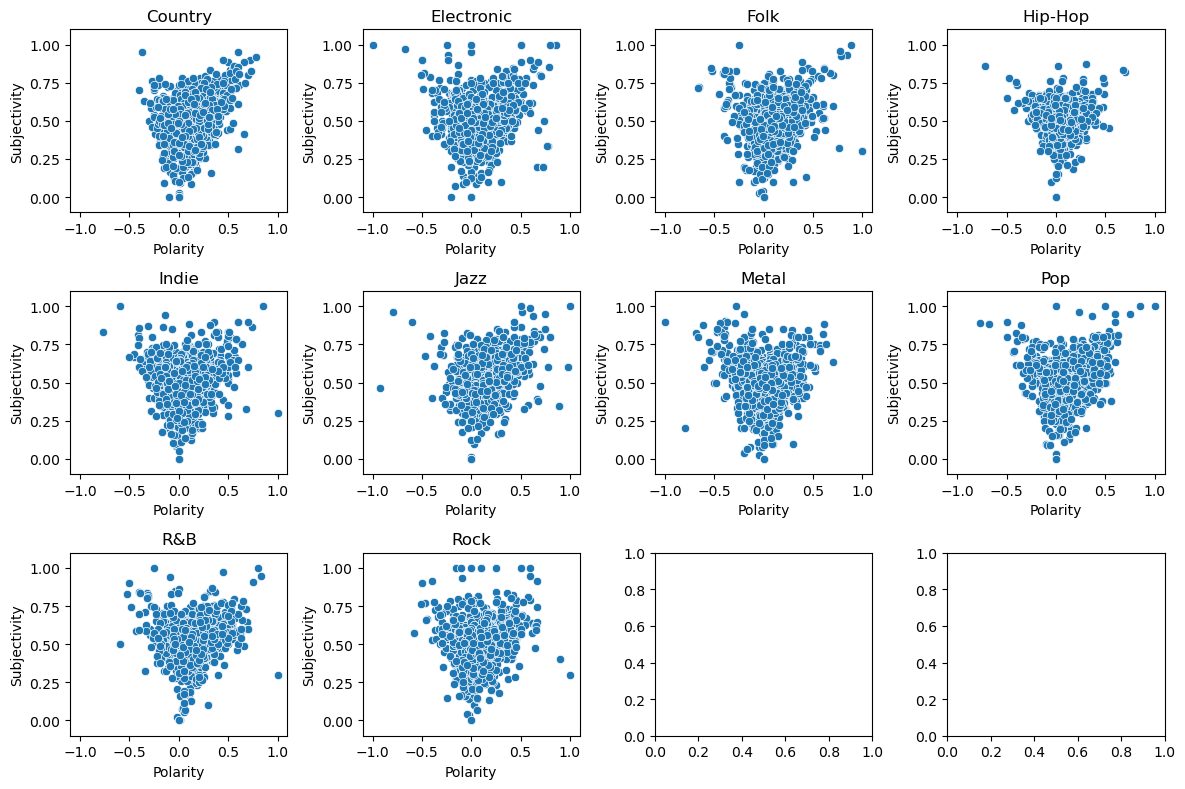

In [21]:
# Create the subplot figure
fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='Polarity', y='Subjectivity', data=song_data_processed[song_data_processed['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre}')
    axs[row][col].set_xlim(-1.1, 1.1)  # Set x-axis limit
    axs[row][col].set_ylim(-0.1, 1.1)  # Set y-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Trying classification

In [14]:
X = song_data_processed[["Polarity", "Subjectivity"]]
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.137

In [16]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.173

In [17]:
#Random forest
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.14333333333333334

### Get Classification Matrix (of random forest)

In [18]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.23      0.01      0.02       318
           1       0.11      0.02      0.03       308
           2       0.11      0.20      0.14       288
           3       0.20      0.66      0.31       303
           4       0.15      0.04      0.06       320
           5       0.18      0.47      0.26       290
           6       0.20      0.29      0.24       292
           7       0.00      0.00      0.00       292
           8       0.14      0.05      0.07       324
           9       0.15      0.02      0.04       265

    accuracy                           0.17      3000
   macro avg       0.15      0.17      0.12      3000
weighted avg       0.15      0.17      0.12      3000



c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

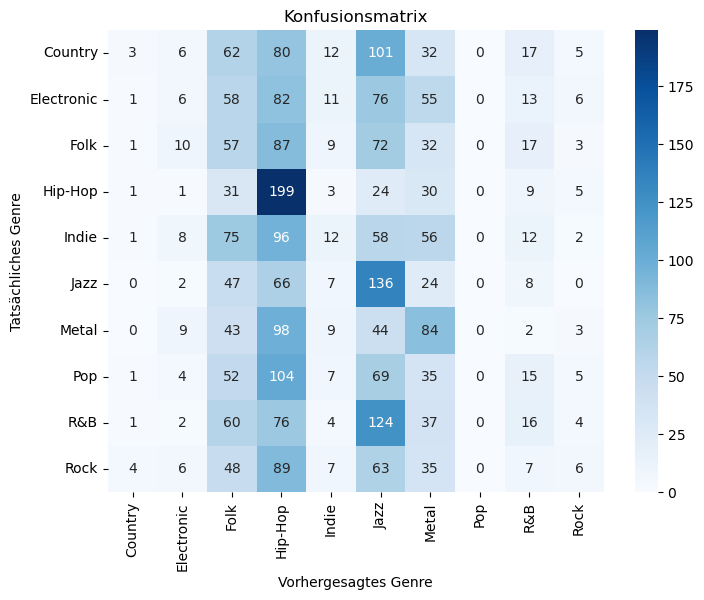

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.title('Konfusionsmatrix')
plt.show()

In [20]:
song_data_processed[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Anwendung der sentiment analyse mithilfe der python textblob bibliothekt (Ergebnis in form von polarity & subjectivity)
- Investigating whether there is a correlation between the sentiments and the song genres, using boxplots, barcharts and Scatterplots
- Investigating whether it is possible to predict a genre based on its sentiments

### Ergebnis
- Die meisten songgenres können grundsätzlich positive als auch negative grundsentiments haben
- vor allem Metall und HipHop sind tendenziell eher negativer (was erwartungsgemäß ist), dieser unterschied ist jedoch nicht extrem groß
- Tendenziell sind song sentiments eher positiv
- Im bezug auf subjektivität sind die meisten songs eher neutral (und auch ähnlich neutral)
- Der Scatterplot zeigt, dass durch Sentiment und Subjektivität alleine keine differenzierung der songgenres möglich ist
- Dieses Ergebnis wird bestätigt durch die Anwendung verschiedener Klassifikationsverfahren, die maximal eine accuracy von 0.14 haben
- Bei Betrachtung der Confusion Matrix und des classification reports wird auch hier sichtbar, dass HipHop am besten predicted werden kann. Warum das so ist, kann allein durch betrachtung der Sentiment Analysis Daten allerdings nicht genau ermittelt werden.

### Interpretation
- Obwohl wenige genres tendenziell negativer sind, kann man grundsätzlich vom Song basierten sentiment nicht auf die gesamtheit eines genres schließen. dafür sind lieder innerhalb von genres zu unterschiedlich in ihrer grundstimmung
